## 做题时长测度和模型 (Internal Release I)

* Part of ronfe's MDP laboratory project

### 0. 简介

* Markov Decision Process (https://shimo.im/doc/9E55uK5z5JEoyhy6)
* 每一步的决策，都是当前状态下可用的Actions中，能够取得全局最大增益的Action
* 蓝本：https://modao.cc/app/O4mIFs5CqAYMXHO6J66JFwe5Kicmk1i
    - 前测 - 复习一章（学/练）- 后测
    - 用户模型：六度能力体系、已掌握知识点清单
    - 课程模型：？

---

* 知识点相对于用户的Value
    - 知识点所归属的能力（技能）：人工/经验，已具备
    - 知识点掌握难易度
        - 知识点类型： 已具备
        - 所属主题在章节的顺序： 已具备
        - 知识点在主题中的顺序： 已具备
        - 有效观看视频长度分布函数：？
        - 交互题作答比例：？（Videology II）
        - 知识点通过率~目标层首答正确率：可计算
        - 知识点题目答题时长： OK 今天就是分享这个

### 1. 准备数据

* 选取埋点：videoFinished / videoQuitted / problemAnswered
* 清洁
    - 移除缺少eventTime / device字段的埋点（无效数据）
    - 移除problemAnswered中，duration小于1或大于等于2000的埋点（奇值数据）
    - 移除video埋点中，duration小于5或大于等于2000的埋点 （奇值数据）
    - 保留必要字段，统一Schema
    
---

```
{
    "_id" : ObjectId("57d6ec11822397213ef4df81"),
    "eventTime" : 1473647615900,
    "user" : ObjectId("5791a0eb8c399674053b9d1c"),
    "serverTime" : ISODate("2016-09-12T02:33:36.037Z"),
    "location" : "北京市",
    "action" : "q",
    "correct" : false,
    "duration" : 7.53,
    "topicId" : "54cc72dfabc5bbb971f99bb3",
    "level" : 3
  }
  {
    "_id" : ObjectId("57d6ec14822397213ef545b7"),
    "eventTime" : 1473665154586,
    "user" : ObjectId("56757adab5a5a8a515d808c0"),
    "serverTime" : ISODate("2016-09-12T07:26:55.085Z"),
    "location" : "北京市",
    "action" : "v",
    "topicId" : "555401d7f577fa46266625e7",
    "duration" : 5,
    "videoRatio" : 0.0131128280173929
}```

### 2. 题目作答时长频率分布

* 以层为单位，同一层不同题目合并统计
* 以“负数的定义”第1层题目为例，获取所有完成该层题目的时长

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


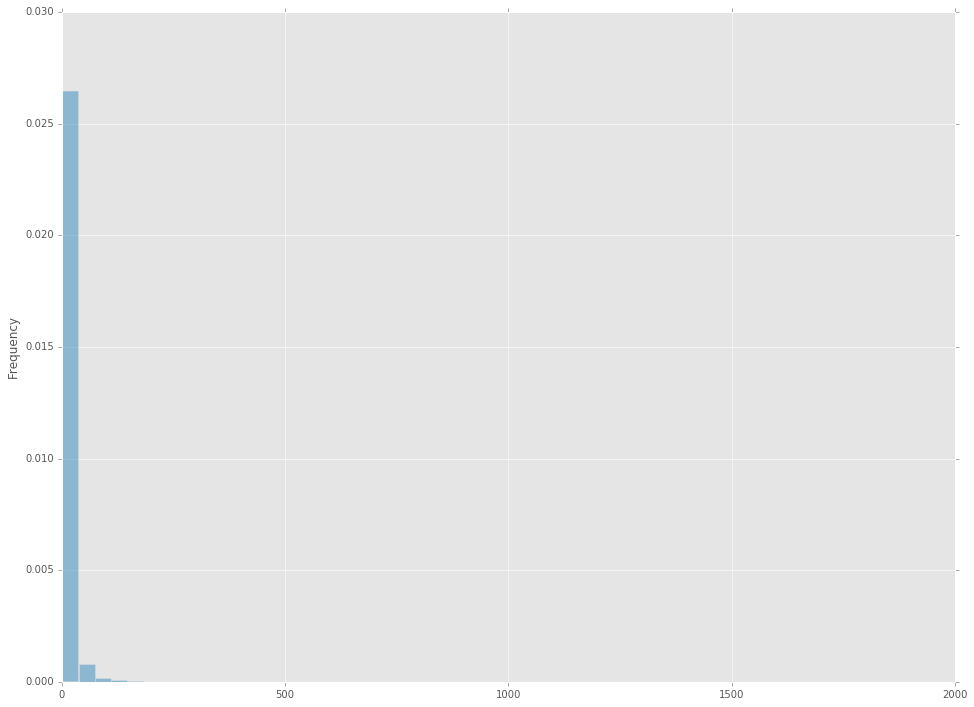

In [4]:
%matplotlib inline

from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

conn = MongoClient('10.8.8.111:27017')
mdp = conn['ronfedb']['mdp']

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 1}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]
x = list(mdp.aggregate(pipeline))
data = pd.Series(x[0]['times'])

# visualize
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])

* 移除+/-1.64标准差外的数据

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


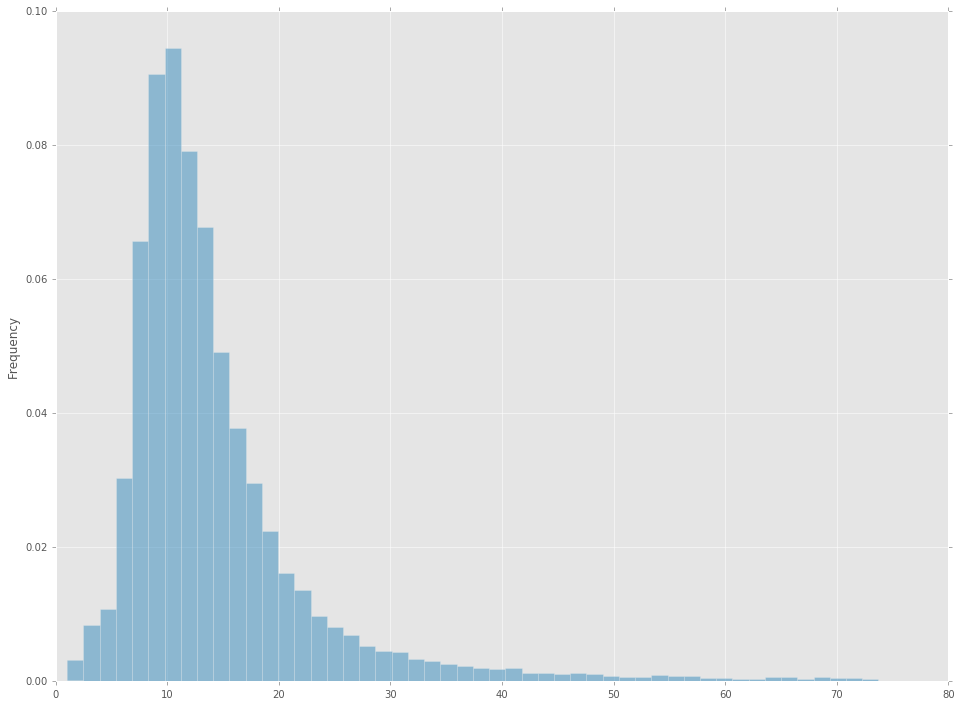

In [5]:
# remove extreme values
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

data = reject_outliers(data, m=1.64)
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])

### 3. 寻找最佳拟合的分布模型

* 尽可能搜寻可用的分布模型
    - ```scipy.stats```
* 用每一个模型对数据进行一次拟合
* 计算拟合曲线与数据的标准误（SE）
* 返回SE最小的模型及参数

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


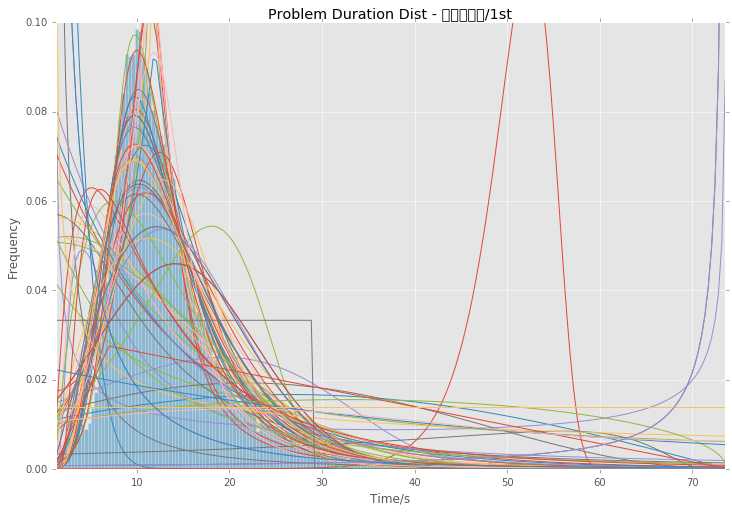

In [6]:
%matplotlib inline

import warnings
import scipy.stats as st
import statsmodels as sm


# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)


# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=200, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Problem Duration Dist - 负数的定义/1st')
ax.set_xlabel(u'Time/s')
ax.set_ylabel('Frequency')

### 4. 结果

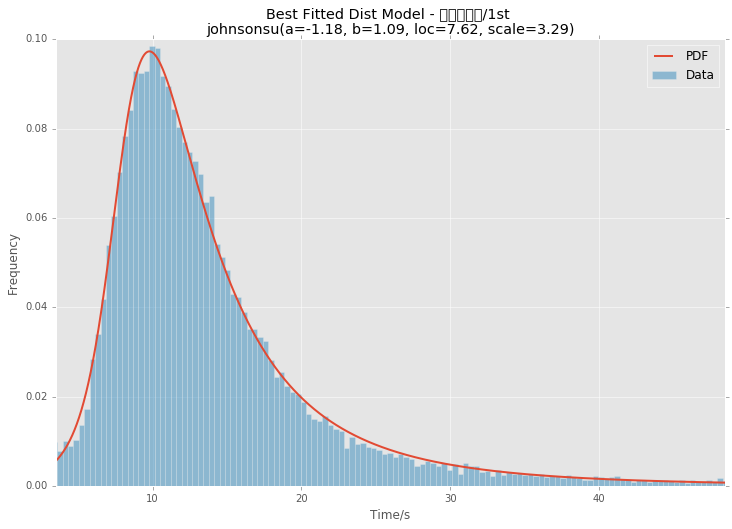

In [7]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=200, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Best Fitted Dist Model - 负数的定义/1st \n' + dist_str)
ax.set_xlabel(u'Time/s')
ax.set_ylabel('Frequency')

### Johnson SU

* http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.johnsonsu.html
* https://en.wikipedia.org/wiki/Johnson%27s_SU-distribution

### 5. 其他层分布

| 层序号 | 整体             | 正确           | 错误                |
|--------|------------------|----------------|---------------------|
| 1      | Johnson SU       | NCT            | Folded Couchy       |
| 2      | Inverted Weibull | Inverted Gamma | Mielke’s Beta-Kappa |
| 3      | Johnson SU       | Johnson SU     | Fisk                |
| 4      | NCT              | NCT            | NCT                 |

### 6. 四层Johnson SU

In [11]:
pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 1}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']
bins = 200
xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

y, x = np.histogram(data, bins=bins, normed=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

out = st.johnsonsu.fit(data)
arg = out[:-2]
loc = out[-2]
scale = out[-1]
pdf = st.johnsonsu.pdf(x, loc=loc, scale=scale, *arg)
pd.Series(pdf, x).plot(ax=ax)


pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 2}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']

xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

y, x = np.histogram(data, bins=bins, normed=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

out = st.johnsonsu.fit(data)
arg = out[:-2]
loc = out[-2]
scale = out[-1]
pdf = st.johnsonsu.pdf(x, loc=loc, scale=scale, *arg)
pd.Series(pdf, x).plot(ax=ax)

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 3}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']
bins = 200

xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

y, x = np.histogram(data, bins=200, normed=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

out = st.johnsonsu.fit(data)
arg = out[:-2]
loc = out[-2]
scale = out[-1]
pdf = st.johnsonsu.pdf(x, loc=loc, scale=scale, *arg)
pd.Series(pdf, x).plot(ax=ax)

pipeline = [
    {"$match": {"action": "q", "topicId": "54cc72dfabc5bbb971f99bb3", "level": 4}},
    {"$group": {"_id": None, "times": {"$push": "$duration"}}}
]

x = list(mdp.aggregate(pipeline))
x = x[0]['times']

xx = reject_outliers(np.array(x), m=1.64)
data = pd.Series(xx)

y, x = np.histogram(data, bins=bins, normed=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

out = st.johnsonsu.fit(data)
arg = out[:-2]
loc = out[-2]
scale = out[-1]
pdf = st.johnsonsu.pdf(x, loc=loc, scale=scale, *arg)
pd.Series(pdf, x).plot(ax=ax)

### 6. 下一步

* 确定一个更合适的模型
    - 内部一致性
    - 外部一致性